In [37]:
# data collection - DONE

# data inspection

# feature engineering
    # source data
    # preprocessing
    # tokenization
    # removing stopwords
    # Vectoriztion
# selecting and tuning a model? Which model?
# inspecting a model
# model iteration - trying different models


In [36]:
from searchtweets import load_credentials, collect_results, gen_rule_payload
search_args = load_credentials(yaml_key="search_tweets_30_day_dev", filename='keys.yaml')

In [18]:
# specifically searching for topic 'bollywood', next -> search for industry like cars, sme, devops 
rule = gen_rule_payload('bollywood', from_date='2018-08-22', to_date='2018-08-29')

In [19]:
rule

'{"query": "bollywood", "toDate": "201808290000", "fromDate": "201808220000"}'

In [13]:
def maybe_get_tweets(file_name, rule=None, max_results=1000):
    try:
        tweets = []
        with open(file_name, 'r') as infile:
            logging.warning("reading cached tweets")
            for line in infile:
                tweets.append(Tweet(json.loads(line)))

    except FileNotFoundError:
        if rule is not None:
            logging.warning("collecting tweets from the API")
            tweets = collect_results(rule,
                                     max_results=max_results,
                                     result_stream_args=search_args)
        else:
            logging.error("rule is not defined; please supply a valid rule for the query")
            raise KeyError
        # write sample to disk
        if not os.path.isdir("data"):
            os.mkdir("data")
        with open(file_name, 'w') as outfile:
            for tw in tweets:
                outfile.write(json.dumps(tw) + '\n')

    return tweets

In [29]:
tweets = collect_results(rule,max_results=1000,result_stream_args=search_args)

In [24]:
from collections import Counter
import itertools as it
import json
import logging
import os
import re
import string
import sys
import yaml

In [30]:
len(tweets)

1000

In [38]:
import pandas as pd

In [39]:
tweets[0]

{'created_at': 'Tue Aug 28 23:59:48 +0000 2018',
 'id': 1034591408106229768,
 'id_str': '1034591408106229768',
 'text': 'https://t.co/vi3WwZFqND\n\nstrip teens milf 3gp naked masturbation fake hospital for porn mistress porno lover beauty… https://t.co/QIjx36M16C',
 'source': '<a href="https://spirridde488.wordpress.com" rel="nofollow">Mindy Bingham\'s 1951998 Blog</a>',
 'truncated': True,
 'in_reply_to_status_id': None,
 'in_reply_to_status_id_str': None,
 'in_reply_to_user_id': None,
 'in_reply_to_user_id_str': None,
 'in_reply_to_screen_name': None,
 'user': {'id': 1018062405958545408,
  'id_str': '1018062405958545408',
  'name': 'Sweet Lesbian Porno Movies Online📍📺',
  'screen_name': 'mindy_bingham',
  'location': 'United States',
  'url': 'http://rualdiscyo.ml/',
  'description': None,
  'translator_type': 'none',
  'protected': False,
  'verified': False,
  'followers_count': 72,
  'friends_count': 0,
  'listed_count': 0,
  'favourites_count': 0,
  'statuses_count': 5727,
  'cre

In [47]:
tweet_df = pd.DataFrame({'ts': [t.created_at_datetime  for t in tweets],
                        'text': [t.all_text for t in tweets],
                        'uid': [t.user_id for t in tweets]
                        })

In [53]:
tweet_df['ts'] = pd.to_datetime(tweet_df['ts'])

In [54]:
tweet_df.head()

,ts,text,uid
0,2018-08-28 23:59:48,https://t.co/vi3WwZFqND\n\nstrip teens milf 3g...,1018062405958545408
1,2018-08-28 23:59:38,https://t.co/Gv5SebwhaR\n\nswallow model rocco...,1009662777802227712
2,2018-08-28 23:59:32,Actor @iamsrk wants equal pay for male and fem...,879279772475441152
3,2018-08-28 23:59:32,https://t.co/nyb6m1lyFc\n\nbbw younger the tee...,1021783910999629826
4,2018-08-28 23:59:12,Exclusive! Birthday girl Shilpa Shinde on bein...,984320885514383360


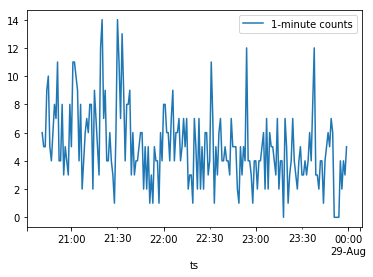

In [57]:
(tweet_df[['ts', 'text']]
 .set_index('ts')
 .resample('T')
 .count()
 .rename(columns=dict(text='1-minute counts'))
 .plot()
);

In [59]:
from nltk.tokenize.casual import TweetTokenizer
import string

In [61]:
string.printable

'0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~ \t\n\r\x0b\x0c'

In [96]:
def get_all_tokens(tweet_list):
    """
    Helper function to generate a list of text tokens from concatenating
    all of the text contained in Tweets in `tweet_list`
    """
    # concat entire corpus
    all_text = ' '.join((t.all_text for t in tweet_list))
    # tokenize
    tokens = (TweetTokenizer(preserve_case=False,
                            reduce_len=True,
                            strip_handles=False)
              .tokenize(all_text))
    # remove symbol-only tokens for now
    tokens = [tok for tok in tokens if not tok in string.punctuation]
    return tokens

In [97]:
tokens = get_all_tokens(tweets)

In [98]:
len(tokens)

24750

In [86]:
from nltk.util import everygrams

In [99]:
top_grams = Counter(everygrams(tokens, min_len=2, max_len=4))
top_grams.most_common(25)

[(('bollywood', 'nudes'), 202),
 (('nudes', 'hd'), 202),
 (('bollywood', 'nudes', 'hd'), 202),
 (('in', 'bollywood'), 58),
 (('’', 's'), 55),
 (('of', 'bollywood'), 48),
 (('of', 'the'), 40),
 (('in', 'the'), 34),
 (('film', 'bollywood'), 24),
 (('y', 'a'), 24),
 (('fake', 'agent'), 23),
 (('#pallywood', '#mensongepalestinien'), 23),
 (('#mensongepalestinien', 'cette'), 23),
 (('cette', 'image'), 23),
 (('image', 'fait'), 23),
 (('fait', 'le'), 23),
 (('le', 'tour'), 23),
 (('tour', 'des'), 23),
 (('des', 'comptes'), 23),
 (('comptes', 'palestiniens'), 23),
 (('palestiniens', 'jeune'), 23),
 (('jeune', 'palestinien'), 23),
 (('palestinien', 'qui'), 23),
 (('qui', 'a'), 23),
 (('a', 'refusé'), 23)]

In [100]:
# create a filter series matching "file"
mask = tweet_df['text'].str.lower().str.contains("film")

In [101]:
tweet_df[mask][['text']]

,text
15,https://t.co/dFmeesZgHc\n\n4k dick porn girl m...
23,@Official_MNCTV min minggu esok mohon tayangin...
46,Mauji and Mamta back from #SuiDhaagaInJaipur p...
49,Sharing these pics shared with me by @iamsrk f...
56,#Pallywood #MensongePalestinien\n\nCette image...
69,Shah Rukh Khan says he has never been offered ...
73,Shah Rukh Khan &amp; Rani Mukerji to feature o...
74,.@iHrithik SLAMS reports of @DishPatani WALKIN...
75,Shah Rukh Khan on Hollywood: I'd like Tom Crui...
80,#Pallywood #MensongePalestinien\n\nCette image...


In [94]:
tweets_larger = maybe_get_tweets(file_name="data/larger-bollywood.json",
                          rule=rule,
                          max_results=20000)

In [102]:
print("hello world")

hello world


In [103]:
tokens_larger = get_all_tokens(tweets_larger)

In [113]:
from stop_words import get_stop_words
stop_words = get_stop_words('english')

tokens_larger = [tok for tok in tokens_larger if not tok in stop_words]
tokens_larger = [tok for tok in tokens_larger if not tok in string.punctuation]

In [114]:
Counter(everygrams(tokens_larger, min_len=1, max_len=4)).most_common(25)

[(('bollywood',), 9053),
 (('#bollywood',), 2993),
 (('ा',), 2609),
 (('’',), 2582),
 (('s',), 2470),
 (('khan',), 2247),
 (('े',), 2013),
 (('’', 's'), 1642),
 (('ी',), 1595),
 (('@iamsrk',), 1477),
 (('क',), 1458),
 (('ali',), 1394),
 (('one',), 1351),
 (('ali', 'khan'), 1323),
 (('sara',), 1253),
 (('sara', 'ali'), 1246),
 (('sara', 'ali', 'khan'), 1246),
 (('्',), 1234),
 (('will',), 1176),
 (('...',), 1162),
 (('actor',), 1158),
 (('film',), 1148),
 (('ि',), 1138),
 (('hd',), 1129),
 (('porn',), 1123)]

In [115]:
Counter(everygrams(tokens_larger, min_len=2, max_len=4)).most_common(25)

[(('’', 's'), 1642),
 (('ali', 'khan'), 1323),
 (('sara', 'ali'), 1246),
 (('sara', 'ali', 'khan'), 1246),
 (('bollywood', 'nudes'), 877),
 (('nudes', 'hd'), 877),
 (('bollywood', 'nudes', 'hd'), 877),
 (('trolling', 'sara'), 641),
 (('khan', 'visiting'), 641),
 (('visiting', 'temple'), 641),
 (('secular', 'fabric'), 641),
 (('trolling', 'sara', 'ali'), 641),
 (('ali', 'khan', 'visiting'), 641),
 (('khan', 'visiting', 'temple'), 641),
 (('trolling', 'sara', 'ali', 'khan'), 641),
 (('sara', 'ali', 'khan', 'visiting'), 641),
 (('ali', 'khan', 'visiting', 'temple'), 641),
 (('bollywood', 'celebrities'), 613),
 (('south', 'superstar'), 595),
 (('shilpa', 'shinde'), 587),
 (('amrita', 'singh'), 580),
 (('celebrities', 'support'), 580),
 (('bollywood', 'celebrities', 'support'), 580),
 (('radicals', 'abusing'), 579),
 (('abusing', 'trolling'), 579)]

In [116]:
t = tweets_larger[0]

In [117]:
def tweets_to_df(tweets):
    """Helper func to extract specific tweet features into a dataframe."""
    tweet_df = pd.DataFrame({'ts': [t.created_at_datetime for t in tweets],
                             'text': [t.all_text for t in tweets],
                             'uid': [t.user_id for t in tweets],}
                           )
    # creating a datetimeindex will allow us to do more timeseries manipulations
    tweet_df['ts'] = pd.to_datetime(tweet_df['ts'])
    return tweet_df

In [118]:
tweeets_df_larger = tweets_to_df(tweets_larger)

In [119]:
tweeets_df_larger.head()tweeets_df_larger

,ts,text,uid
0,2018-08-28 23:59:48,https://t.co/vi3WwZFqND\n\nstrip teens milf 3g...,1018062405958545408
1,2018-08-28 23:59:38,https://t.co/Gv5SebwhaR\n\nswallow model rocco...,1009662777802227712
2,2018-08-28 23:59:32,Actor @iamsrk wants equal pay for male and fem...,879279772475441152
3,2018-08-28 23:59:32,https://t.co/nyb6m1lyFc\n\nbbw younger the tee...,1021783910999629826
4,2018-08-28 23:59:12,Exclusive! Birthday girl Shilpa Shinde on bein...,984320885514383360


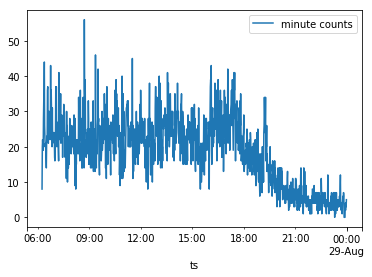

In [120]:
(tweeets_df_larger[['ts','text']]
 .set_index('ts')
 .resample('T')
 .count()
 .rename(columns=dict(text='minute counts'))
 .plot()
);

In [123]:
unique_user_cnt = len(set(tweeets_df_larger['uid']))

unique_user_cnt

10807

In [126]:
i = 151

(tweets_larger[i].name, tweets_larger[i].screen_name, tweets_larger[i].bio)

('Aleena Mashhood',
 'filmwaali',
 'Filmmaker, Entrepreneur, Blogger, Co-founder at Shikanjbeen. Other Instagram: @filmwaali')

In [127]:
def replace_urls(in_string, replacement=None):
    """Replace URLs in strings. See also: ``bit.ly/PyURLre``

    Args:
        in_string (str): string to filter
        replacement (str or None): replacment text. defaults to '<-URL->'

    Returns:
        str
    """
    replacement = '<-URL->' if replacement is None else replacement
    pattern = re.compile('(https?://)?(\w*[.]\w+)+([/?=&]+\w+)*')
    return re.sub(pattern, replacement, in_string)

In [128]:
# add fake url for demonstration
replace_urls(tweets[i].bio + " http://bit.ly/4atsdfzc")

'Filmmaker, Entrepreneur, Blogger, Co-founder at Shikanjbeen. Other Instagram: @filmwaali <-URL->'

In [129]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [158]:
languages = ['english',
             'spanish',
             'portuguese',
             'german',
             'french',
             'italian',
             'turkish'
            ]

# collect and dedupe
my_stopwords = list(set(it.chain.from_iterable((get_stop_words(lang)
                                                for lang in languages))))
len(my_stopwords)

def my_tokenizer(in_string):
    """
    Convert `in_string` of text to a list of tokens using NLTK's TweetTokenizer
    """
    # reasonable, but adjustable tokenizer settings
    tokenizer = TweetTokenizer(preserve_case=False,
                               reduce_len=True,
                               strip_handles=False)
    tokens = tokenizer.tokenize(in_string)
    return tokens

def make_punc_stopwords(max_length=4):
    """Generates punctuation 'words' up to
    ``max_length`` characters.
    """
    def punct_maker(length):
        return ((''.join(x) for x in it.product(string.punctuation,
                                                repeat=length)))
    words = it.chain.from_iterable((punct_maker(length)
                                    for length in range(max_length+1)))
    return list(words)


my_stopwords = list(it.chain(my_stopwords, make_punc_stopwords(max_length=4)))

print('current count of stopwords: {}'.format(len(my_stopwords)))
print('example punctuation words:\n {}'.format(my_stopwords[-10:]))

current count of stopwords: 1083864
example punctuation words:
 ['~~~[', '~~~\\', '~~~]', '~~~^', '~~~_', '~~~`', '~~~{', '~~~|', '~~~}', '~~~~']


In [168]:
vec = TfidfVectorizer(preprocessor=replace_urls, 
                      tokenizer=my_tokenizer,
                      stop_words=my_stopwords, 
                      max_features=unique_user_cnt//100)

In [169]:
print(vec)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=108, min_df=1,
        ngram_range=(1, 1), norm='l2',
        preprocessor=<function replace_urls at 0x000001BAE4E08268>,
        smooth_idf=True,
        stop_words=['fra', 'sobre', 'over', 'yetmiþ', 'facevano', 'too', 'hubo', 'mais', 'tenía', 'são', 'avoir', 'yours', 'estejamos', 'fomos', 'çok', 'stessi', 'pela', 'tua', 'stavano', 'staremo', 'nell', 'zur', 'fanno', 'forem', 'hab', 'sommes', 'hubimos', 'houverão', 'avais', 'quasi', 'tendríamos', 'are...>', '~~~?', '~~~@', '~~~[', '~~~\\', '~~~]', '~~~^', '~~~_', '~~~`', '~~~{', '~~~|', '~~~}', '~~~~'],
        strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=<function my_tokenizer at 0x000001BADD0EDC80>,
        use_idf=True, vocabulary=None)


In [170]:
# create one entry per user
unique_user_map = {t.user_id: t.bio for t in tweets_larger}

# we need to maintain the same ordering of users and bios
unique_users = []
unique_bios = []
for user,bio in unique_user_map.items():
    unique_users.append(user)
    if bio is None:
        # special case for empty bios
        bio = ''
    unique_bios.append(bio)

In [171]:
# calculate the data matrix
bio_matrix = vec.fit_transform(unique_bios)

bio_matrix

<10807x108 sparse matrix of type '<class 'numpy.float64'>'
	with 22031 stored elements in Compressed Sparse Row format>

In [172]:
for i,bio in enumerate(unique_bios[:10]):
    print(i,': ', bio.replace('\n',' '))

0 :  
1 :  
2 :  The sky is dark,the roads are slippery,the owls are hooting,but the motivation are those trees and the destination is not so far...
3 :  
4 :  
5 :  
6 :  I αdore Kαtrinα Kαif, she‘s the queen 👑💅🏻 | I‘m α sociαl pedαgogue 🦋 | 🎬 Zero, 21.dec.18
7 :  
8 :  si saben cómo me pongo, pa que me invitan?
9 :  


In [173]:
(pd.DataFrame(bio_matrix[:10].todense(),
              columns=[x for x in vec.get_feature_names()])
 # experiment by choosing any range of feature indices (alphabetical order)
 .iloc[:,90:110])

,’,•,♥,❤,️,🇮,🇳,👉,💕,💖,💪,🔥,😊,😍,😎,😘,🙏,🚩
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [174]:
vec.get_feature_names()[:10]

['<-url->',
 '@iamsrk',
 'account',
 'always',
 'best',
 'big',
 'biggest',
 'bollywood',
 'cricket',
 'endorsement']

In [175]:
vec.get_feature_names()[40:45]

['rts', 's', 'salman', 'srk', 'student']

In [176]:
from sklearn.cluster import  KMeans

In [179]:
best_k = 200 # ???
seed = 42 # ???

km_model = KMeans(n_clusters=best_k, n_jobs=-1, random_state=seed)
km_model.fit(bio_matrix)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=200, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

In [183]:
import matplotlib.pyplot as plt
import numpy as np

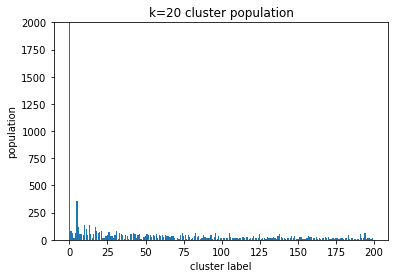

In [196]:
smaller_k = 20
plt.bar(range(len(set(km_model.labels_))), np.bincount(km_model.labels_))

plt.ylabel('population')
plt.xlabel('cluster label')
plt.title('k={} cluster population'.format(smaller_k));

plt.ylim(0, 2000);

In [192]:
def strongest_features(model, vectorizer, topk=10):
    """
    Helper function to display a simple text representation of the top-k most
    important features in our fit model and vectorizer.

    model: sklearn model
    vectorizer: sklearn vectorizer
    topk: k numbers of words to get per cluster

    """
    # these parts are model-independent
    m_name = model.__class__.__name__
    features = vectorizer.get_feature_names()
    # different calculations per model type
    if m_name is 'KMeans':
        relevant_labels = list(set(model.labels_))
        centroids = model.cluster_centers_.argsort()[:,::-1]
        for this_label in relevant_labels:
            print('Cluster {}:'.format(this_label), end='')
            for ind in centroids[this_label, :topk]:
                print(' {}'.format(features[ind]), end='')
            print()
    elif m_name is 'HDBSCAN':
        # ignore noise labels
        relevant_labels = [ x for x in set(model.labels_) if x >= 0 ]
        for this_label in relevant_labels:
            matching_rows = np.where(hdbs.labels_ == this_label)[0]
            coeff_sums = np.sum(bio_matrix[matching_rows], axis=0).A1
            sorted_coeff_idxs = np.argsort(coeff_sums)[::-1]
            print('Cluster {}: '.format(this_label), end='')
            for idx in sorted_coeff_idxs[:topk]:
                print('{} '.format(features[idx]), end='')
            print()
    else:
        raise NotImplementedError('This helper method currently only supports KMeans and HDBSCAN models')


In [197]:
strongest_features(km_model, vec, topk=15)

Cluster 0: ु ट heart ै hindu व क म ् life indian music news nationalist movies
Cluster 1: life fan indian ️ best proud always heart biggest 💕 😊 live 😍 ❤ <-url->
Cluster 2: one love world <-url-> ️ 😎 life fan news proud ❤ music account hard big
Cluster 3: big srk 🙏 music bollywood lover student @iamsrk khan life follow 😎 love fan heart
Cluster 4: hard fan indian <-url-> lover proud follow ❤ entertainment student 😍 ️ like bollywood 🇳
Cluster 5: <-url-> indian heart hindu rts proud first like love nationalist bollywood ❤ u ️ endorsement
Cluster 6: ️ ❤ fan love life 😘 @iamsrk proud lover follow <-url-> khan 🙏 🇮 movie
Cluster 7: like love <-url-> ❤ khan music follow 😎 life fan ’ endorsement account srk everything
Cluster 8: े ा ् र ी ि क ं ो द म त स ह ु
Cluster 9: lover life love proud ❤ indian ️ movie live bollywood nationalist student u rts fan
Cluster 10: fan movie follow ❤ salman music bollywood film cricket <-url-> account us hard love big
Cluster 11: news <-url-> indian latest enterta

Cluster 115: । engineer ् े hindu स ं ु ’ india ि proud indian व त
Cluster 116: life <-url-> world engineer like proud srk ❤ bollywood news fan 🙏 ♥ always best
Cluster 117: ं ी ा ह े ि ू म क ् ज द ै ो न
Cluster 118: s u ❤ love 😊 bollywood fan follow 🙏 😎 life <-url-> big srk @iamsrk
Cluster 119: ी ा व ु ् र ब ि क ं ल स े द म
Cluster 120: endorsement personal tweets <-url-> rts like proud 💕 entertainment india account music first hard twitter
Cluster 121: 🔥 ❤ 😍 love srk student lover proud 😊 💕 fan 👉 @iamsrk 🙏 ்
Cluster 122: <-url-> official twitter one indian film tweets endorsement movies bollywood like love salman world follow
Cluster 123: cricket love ❤ ️ lover first twitter srk big india 💕 music proud 😍 life
Cluster 124: latest entertainment news world <-url-> movies politics india first hindu best music bollywood indian official
Cluster 125: salman khan fan big ❤ love <-url-> hard proud life 😍 movie u 😊 ♥
Cluster 126: movie hard fan lover indian 😎 biggest world khan vijay personal m

In [198]:
def cluster_sample(orig_text, model, idx, preview=15):
    """
    Helper function to display original bio for
    those users modeled in cluster `idx`.
    """
    for i,idx in enumerate(np.where(model.labels_ == idx)[0]):
        print(orig_text[idx].replace('\n',' '))
        print()
        if i > preview:
            print('( >>> truncated preview <<< )')
            break

In [208]:
# feel free to modify this
interest_idx = 10

cluster_sample(unique_bios, km_model, interest_idx)

🇵🇰 New Yorker in TX. Diversity Reporter @startelegram. Past: @pajaropolitico, @WSJ, @sbstatesman. CUNYJ grad. ⚽ fan. EN/ES/Broken Urdu. Chisme por DM.

Huge @Shahidkapoor and @AmritaRao fan

Reluctant Dentist, Beerholic, Teaholic, Mufc fan

Fan of Screen presence of AD on 70 MM screen.

ThalapathyVIJAY FAN

ThalapathyVIJAY Fan @Karnataka

Fascist Hindutvawadi. NaMo, BJP & RSS fan. Allergic to sickulars, libtards, Islamists, Christian imperialists, Zionists, INC, communists and secular BJP/RSS.

Harshvardhan Rane's fan

Hardcore Hrithik Fan

Husband|Filmmaker|Gamer|Tech Reviewer. DC Comics fan (#DCEU) |Gaming enthusiast (#PlayStation)|Man Utd fan (#MUFC) & Host of The Review with Brian Emeka Show.

True Pakistani & fan @mayaali07 @Ayezakhan_ak crazy for cricket fan of @razzaqofficial & @sharjeelleo14 & in films fan of @ajaydevgn & kareena kapoor

Greek Fan Club for all things @ElliAvrRam

Fan of Emraan Hashmi

@Crazy fan of Mr. @iHrithik #MechanicalEngineer.......    Member of @HRFC_ODI

Wall time: 45.1 s


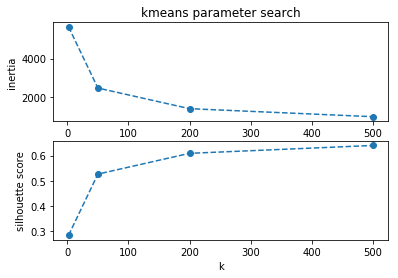

In [211]:
%%time
# compare a broad range of ks to start
ks = [2, 50, 200, 500]


# track a couple of metrics
sil_scores = []
inertias = []

# fit the models, save the evaluation metrics from each run
for k in ks:
    logging.warning('fitting model for {} clusters'.format(k))
    model = KMeans(n_clusters=k, n_jobs=-1, random_state=seed)
    model.fit(bio_matrix)
    labels = model.labels_
    sil_scores.append(silhouette_score(bio_matrix, labels))
    inertias.append(model.inertia_)

# plot the quality metrics for inspection
fig, ax = plt.subplots(2, 1, sharex=True)

plt.subplot(211)
plt.plot(ks, inertias, 'o--')
plt.ylabel('inertia')
plt.title('kmeans parameter search')

plt.subplot(212)
plt.plot(ks, sil_scores, 'o--')
plt.ylabel('silhouette score')
plt.xlabel('k');

In [210]:
from sklearn.metrics import silhouette_score

In [212]:
smaller_k = 20
km_model = KMeans(n_clusters=smaller_k, n_jobs=-1, random_state=seed)
km_model.fit(bio_matrix)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=20, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

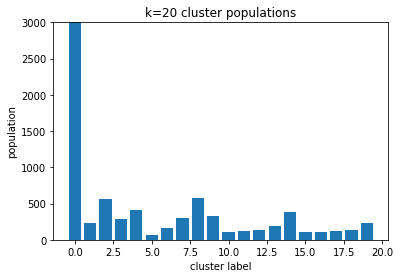

In [213]:
plt.bar(range(len(set(km_model.labels_))), np.bincount(km_model.labels_))

plt.ylabel('population')
plt.xlabel('cluster label')
plt.title('k={} cluster populations'.format(smaller_k));

# truncating the axis again!
plt.ylim(0,3000);

In [215]:
strongest_features(km_model, vec, topk=10)

Cluster 0: 😍 lover 😎 ் student music bollywood 😘 writer india
Cluster 1: news latest bollywood <-url-> india official politics indian twitter movies
Cluster 2: <-url-> fan india us writer official s student love live
Cluster 3: love fan <-url-> india music u live 😘 always proud
Cluster 4: ा ् े ी ि र म ं ह क
Cluster 5: • ❤ ️ love fan account <-url-> life proud khan
Cluster 6: hard fan 😎 vijay love 😘 <-url-> 😍 ❤ 💪
Cluster 7: ️ ❤ fan love ♥ 😍 <-url-> 😘 lover khan
Cluster 8: fan account big biggest khan salman @iamsrk srk vijay lover
Cluster 9: ❤ fan 😍 love 😘 😎 khan @iamsrk 💕 🙏
Cluster 10: like <-url-> one love tweets politics fan life follow live
Cluster 11: engineer fan <-url-> lover writer nationalist indian life hindu film
Cluster 12: ’ s love first follow 🇮 <-url-> twitter account news
Cluster 13: follow us <-url-> latest fan news bollywood twitter official account
Cluster 14: indian proud hindu 🇳 🇮 fan nationalist india <-url-> lover
Cluster 15: just fan love twitter <-url-> life ac

In [220]:
cluster_sample(unique_bios, km_model, 9)

Salam. I'm Taufiq. PriyankaBadBoy. Manager of @Priyanka0nline @Parineeti0nline @VarunDaily 💪   - PC & Pari followed my FCs! Finally met PC on 6/6/2015 in KL! ❤

PROUD TO BE A SIKH☬                           ❤#Akkian❤#Yuvian❤ FOREVER❤

here u will meet a girl full of hopes n dreams❤❤🙈 associated with @HSKPakistan

❤She has it all the heart and the soul👼

Fan of Legend ❤ Akshay Kumar ❤

MUHABBAT,NAFRAT or DOSTI Jab Bhi Kisi Se Karta Bari Shiddat Se Karta Hun❤

Shanatic ❤ Shahid Kapoor ❤ Varuniac ❤ Varun Dhawan ❤ Bollywood lover ❤ my old account @__Yasmin__8 has been locked

For @iamsrk ❤ Forever  Admin OF @SRKEGYPT_CFC ❤ Branch of  @SRKCHENNAIFC ❤  My Old account @yasmine66095489 .. !!  https://www.instagram.com/yasmine66095489/

Teriii Hasrat Hoo Yaa Ibaadat Hoo Tujhko Paana Haii Joo Bhi Surat Hoo Harr Taraf Sach Meinn Sach Ki Chaahat Hoo Lafz Naa Ho Pyaar Balki Aadat Hoo❤

■ Fαɴ Oғ World'ѕ Bιɢɢeѕт Meɢαѕтαr SRK ■ Moнαввαтeιɴ Fαɴвoy 😎 Mαjor Sαмαr Aɴαɴd Iѕ ❤

❤ @radhikamadan01 ❤

‏‏‏‏‏‏‏ح

In [221]:
from MulticoreTSNE import MulticoreTSNE as TSNE

In [222]:
def maybe_fit_tsne(file=None):
    if file is None:
        file = "data/bio_matrix_2d.npy"
    try:
        bio_matrix_2d = np.load(file)
        logging.warning("loading cached TSNE file")
    except FileNotFoundError:
        logging.warning("Fitting TSNE")
        tsne = TSNE(n_components=2,
                    n_jobs=-1,
                    random_state=seed)
        bio_matrix_2d = tsne.fit_transform(bio_matrix.todense())

        np.save(file, bio_matrix_2d)
    return bio_matrix_2d

In [225]:
tsne_file = "data/bio_matrix_2d.npy"
bio_matrix_2d = maybe_fit_tsne(tsne_file)

In [226]:
def get_plottable_df(users, bios, two_d_coords, labels):
    """
    Combine the necessary pieces of data to create a data structure that plays
    nicely with the our 2d tsne chart.

    Note: assumes that all argument data series
    are in the same order e.g. the first user, bio, coords, and label
    all correspond to the same user.
    """
    # set up color palette
    num_labels = len(set(labels))
    colors = sns.color_palette('hls', num_labels).as_hex()
    color_lookup = {v:k for k,v in zip(colors, set(labels))}
    # combine data into a single df
    df = pd.DataFrame({'uid': users,
                       'text': bios,
                       'label': labels,
                       'x_val': two_d_coords[:,0],
                       'y_val': two_d_coords[:,1],
                      })
    # convert labels to colors
    df['color'] = list(map(lambda x: color_lookup[x], labels))
    return df

In [229]:
import seaborn as sns
# pass in the cluster assignments from the kmeans model
km_plottable_bios = get_plottable_df(unique_users, unique_bios, bio_matrix_2d, km_model.labels_)

km_plottable_bios.tail()

,uid,text,label,x_val,y_val,color
10802,230735437,वजनदार शब्द.. खिंचाव युक्त वाक्य । बात पते की....,4,-0.831208,34.997876,#b9db57
10803,884862727122022400,[سب سے پھلے پاکستان ] [زاپختون یم] ACCA No_l...,0,-20.635976,14.945257,#db5f57
10804,888821888226426880,,0,-22.938643,17.318537,#db5f57
10805,1003084968405360640,,0,-12.978513,8.925698,#db5f57
10806,200007635,"“Love is like the wind, you can't see it but y...",10,20.614349,-11.601140,#57d3db


In [230]:
def plot_tsne(df, title='t-SNE plot'):
    # add our DataFrame as a ColumnDataSource for Bokeh
    plot_data = ColumnDataSource(df)
    # configure the chart
    tsne_plot = figure(title=title, plot_width=800, plot_height=700, tools=('pan, box_zoom, reset'))
    # add a hover tool to display words on roll-over
    tsne_plot.add_tools(
        HoverTool(tooltips = """<div style="width: 400px;">(@label) @text</div>""")
    )
    # draw the words as circles on the plot
    tsne_plot.circle('x_val', 'y_val',
                     source=plot_data,
                     color='color',
                     line_alpha=0.2,
                     fill_alpha=0.1,
                     size=7,
                     hover_line_color='black')
    # configure visual elements of the plot
    tsne_plot.title.text_font_size = '12pt'
    tsne_plot.xaxis.visible = False
    tsne_plot.yaxis.visible = False
    tsne_plot.grid.grid_line_color = None
    tsne_plot.outline_line_color = None
    return tsne_plot

In [233]:
show(plot_tsne(km_plottable_bios.sample(5000),
               't-sne projection of kmeans-clustered users ["(cluster #) bio"]'))

In [232]:
from bokeh.plotting import figure, ColumnDataSource, show, output_notebook; output_notebook()
from bokeh.models import HoverTool
from bokeh.palettes import brewer, Viridis256

Loading BokehJS ...